In [1]:
import pandas as pd
import CococoNet_reader
import Go_annotations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [3]:
maize_coconet = CococoNet_reader.read_cococonet('maize')


In [4]:
maize_gene_correlations = pd.read_csv('/data/passala/Collaborator_Data/Penelope_Dave_Collab/Removed_low_correlation_data/spearman_correlation_expressed_over_1_no_outliers_or_files_no_fea.csv',index_col= 0)
maize_gene_correlations = maize_gene_correlations.sort_values('Pearson Correlation with Meristem Width', ascending = False)
maize_gene_correlations

,Pearson Correlation with Meristem Width,P Value
GRMZM2G148198,0.706844,0.000113
GRMZM2G002529,0.695236,0.000163
GRMZM2G059958,0.678843,0.000265
GRMZM2G105787,0.677539,0.000276
GRMZM2G153766,0.673625,0.000308
...,...,...
GRMZM2G319189,-0.619485,0.001246
GRMZM2G095552,-0.638400,0.000788
GRMZM2G128880,-0.641879,0.000722
GRMZM2G121128,-0.651881,0.000558


In [5]:
maize_coconet

,Zm00001d027231,Zm00001d027232,Zm00001d027233,Zm00001d027236,Zm00001d027239,Zm00001d027240,Zm00001d027242,Zm00001d027248,Zm00001d027253,Zm00001d027254,...,ENSRNA049478584,ENSRNA049478607,ENSRNA049478600,Zm00001d000447,Zm00001d000452,ENSRNA049479090,ENSRNA049478822,ENSRNA049478534,ENSRNA049478530,ENSRNA049478881
Zm00001d027231,1.000000,0.078108,0.108838,0.461957,0.800930,0.319041,0.760313,0.660045,0.359478,0.588317,...,0.200135,0.149610,0.229181,0.073480,0.382390,0.226575,0.207282,0.175594,0.204687,0.181446
Zm00001d027232,0.078108,1.000000,0.876293,0.694633,0.214400,0.120976,0.026657,0.382087,0.287655,0.447700,...,0.078462,0.039292,0.145391,0.032343,0.135960,0.032805,0.034453,0.028501,0.069983,0.055660
Zm00001d027233,0.108838,0.876293,1.000000,0.670667,0.536561,0.207089,0.146332,0.328618,0.438306,0.540782,...,0.037824,0.038944,0.072977,0.011442,0.277296,0.015186,0.047389,0.013844,0.054827,0.073887
Zm00001d027236,0.461957,0.694633,0.670667,1.000000,0.656247,0.302919,0.200345,0.460549,0.135278,0.479839,...,0.044842,0.012275,0.142607,0.149006,0.417343,0.057754,0.107408,0.058877,0.062916,0.111273
Zm00001d027239,0.800930,0.214400,0.536561,0.656247,1.000000,0.457139,0.921456,0.095157,0.205044,0.489878,...,0.131221,0.093305,0.128835,0.103421,0.667229,0.090521,0.056203,0.156326,0.082495,0.167994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSRNA049479090,0.226575,0.032805,0.015186,0.057754,0.090521,0.100821,0.150854,0.062272,0.111443,0.113159,...,0.967584,0.893915,0.957201,0.048170,0.045550,1.000000,0.960540,0.979233,0.984839,0.986418
ENSRNA049478822,0.207282,0.034453,0.047389,0.107408,0.056203,0.110707,0.080529,0.061199,0.056742,0.055877,...,0.946128,0.900723,0.943176,0.043434,0.028705,0.960540,1.000000,0.978136,0.966372,0.981323
ENSRNA049478534,0.175594,0.028501,0.013844,0.058877,0.156326,0.145373,0.157355,0.106117,0.138546,0.235968,...,0.972773,0.914726,0.980563,0.119946,0.058226,0.979233,0.978136,1.000000,0.977791,0.985272
ENSRNA049478530,0.204687,0.069983,0.054827,0.062916,0.082495,0.110693,0.165403,0.207660,0.066610,0.087071,...,0.992406,0.935132,0.974161,0.017457,0.031221,0.984839,0.966372,0.977791,1.000000,0.994383


In [6]:
maize_converter = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/v3_tov4_tov5_IDs.csv')
maize_converter

,Gene_IDs_v4,Gene_IDs_v3,Gene_IDs_v5
0,Zm00001d001763,GRMZM2G172529,Zm00001eb065560
1,Zm00001d001765,GRMZM2G046590,Zm00001eb065570
2,Zm00001d001765,GRMZM2G074530,Zm00001eb065570
3,Zm00001d001766,GRMZM5G876379,Zm00001eb065580
4,Zm00001d001767,GRMZM2G154437,Zm00001eb065610
...,...,...,...
28343,Zm00001d054104,GRMZM2G363728,Zm00001eb210110
28344,Zm00001d054105,GRMZM2G169462,Zm00001eb210120
28345,Zm00001d054106,GRMZM2G134889,Zm00001eb210140
28346,Zm00001d054110,GRMZM2G398458,Zm00001eb210160


In [7]:
converted_genes = maize_gene_correlations.merge(right = maize_converter[['Gene_IDs_v4','Gene_IDs_v3']], right_on='Gene_IDs_v3',left_index=True)

In [8]:
converted_genes = converted_genes.sort_values('Pearson Correlation with Meristem Width', ascending = False)
converted_genes = converted_genes.reset_index(drop= True)
converted_genes

,Pearson Correlation with Meristem Width,P Value,Gene_IDs_v4,Gene_IDs_v3
0,0.706844,0.000113,Zm00001d003724,GRMZM2G148198
1,0.678843,0.000265,Zm00001d018102,GRMZM2G059958
2,0.677539,0.000276,Zm00001d047998,GRMZM2G105787
3,0.673625,0.000308,Zm00001d008564,GRMZM2G153766
4,0.648837,0.000604,Zm00001d031822,GRMZM2G457309
...,...,...,...,...
16292,-0.610568,0.001531,Zm00001d010821,GRMZM2G044744
16293,-0.617091,0.001317,Zm00001d009475,GRMZM2G171223
16294,-0.638400,0.000788,Zm00001d050395,GRMZM2G095552
16295,-0.641879,0.000722,Zm00001d017145,GRMZM2G128880


In [9]:
genes_of_interest = converted_genes[:27]
genes_of_interest

,Pearson Correlation with Meristem Width,P Value,Gene_IDs_v4,Gene_IDs_v3
0,0.706844,0.000113,Zm00001d003724,GRMZM2G148198
1,0.678843,0.000265,Zm00001d018102,GRMZM2G059958
2,0.677539,0.000276,Zm00001d047998,GRMZM2G105787
3,0.673625,0.000308,Zm00001d008564,GRMZM2G153766
4,0.648837,0.000604,Zm00001d031822,GRMZM2G457309
5,0.646178,0.000647,Zm00001d017032,GRMZM2G109959
6,0.645793,0.000653,Zm00001d051856,GRMZM2G025671
7,0.645793,0.000653,Zm00001d051856,GRMZM2G025671
8,0.636740,0.000821,Zm00001d037973,GRMZM2G366411
9,0.607523,0.001640,Zm00001d025238,GRMZM2G159720


In [10]:
panda_of_interest_go_style = pd.DataFrame(data = 0, columns = ['Top Genes of Interest'],index= maize_coconet.index)
panda_of_interest_go_style

,Top Genes of Interest
Zm00001d027231,0
Zm00001d027232,0
Zm00001d027233,0
Zm00001d027236,0
Zm00001d027239,0
...,...
ENSRNA049479090,0
ENSRNA049478822,0
ENSRNA049478534,0
ENSRNA049478530,0


In [11]:
panda_of_interest_go_style['Top Genes of Interest'].loc[panda_of_interest_go_style.index.isin(genes_of_interest['Gene_IDs_v4'])] = 1 

In [12]:
panda_of_interest_go_style.sum()

Top Genes of Interest    25
dtype: int64

In [13]:
run_egad(nw = maize_coconet, go = panda_of_interest_go_style, min_count = 5)

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value
Top Genes of Interest,0.397809,14493.127068,0.607725,0.039764


In [14]:
list_of_top_25 = panda_of_interest_go_style.loc[panda_of_interest_go_style['Top Genes of Interest'] == 1].index.to_list()

In [15]:
len(list_of_top_25)

25

In [16]:
coconet_only_25 = maize_coconet.loc[list_of_top_25][maize_coconet.columns[maize_coconet.columns.isin(list_of_top_25)]]

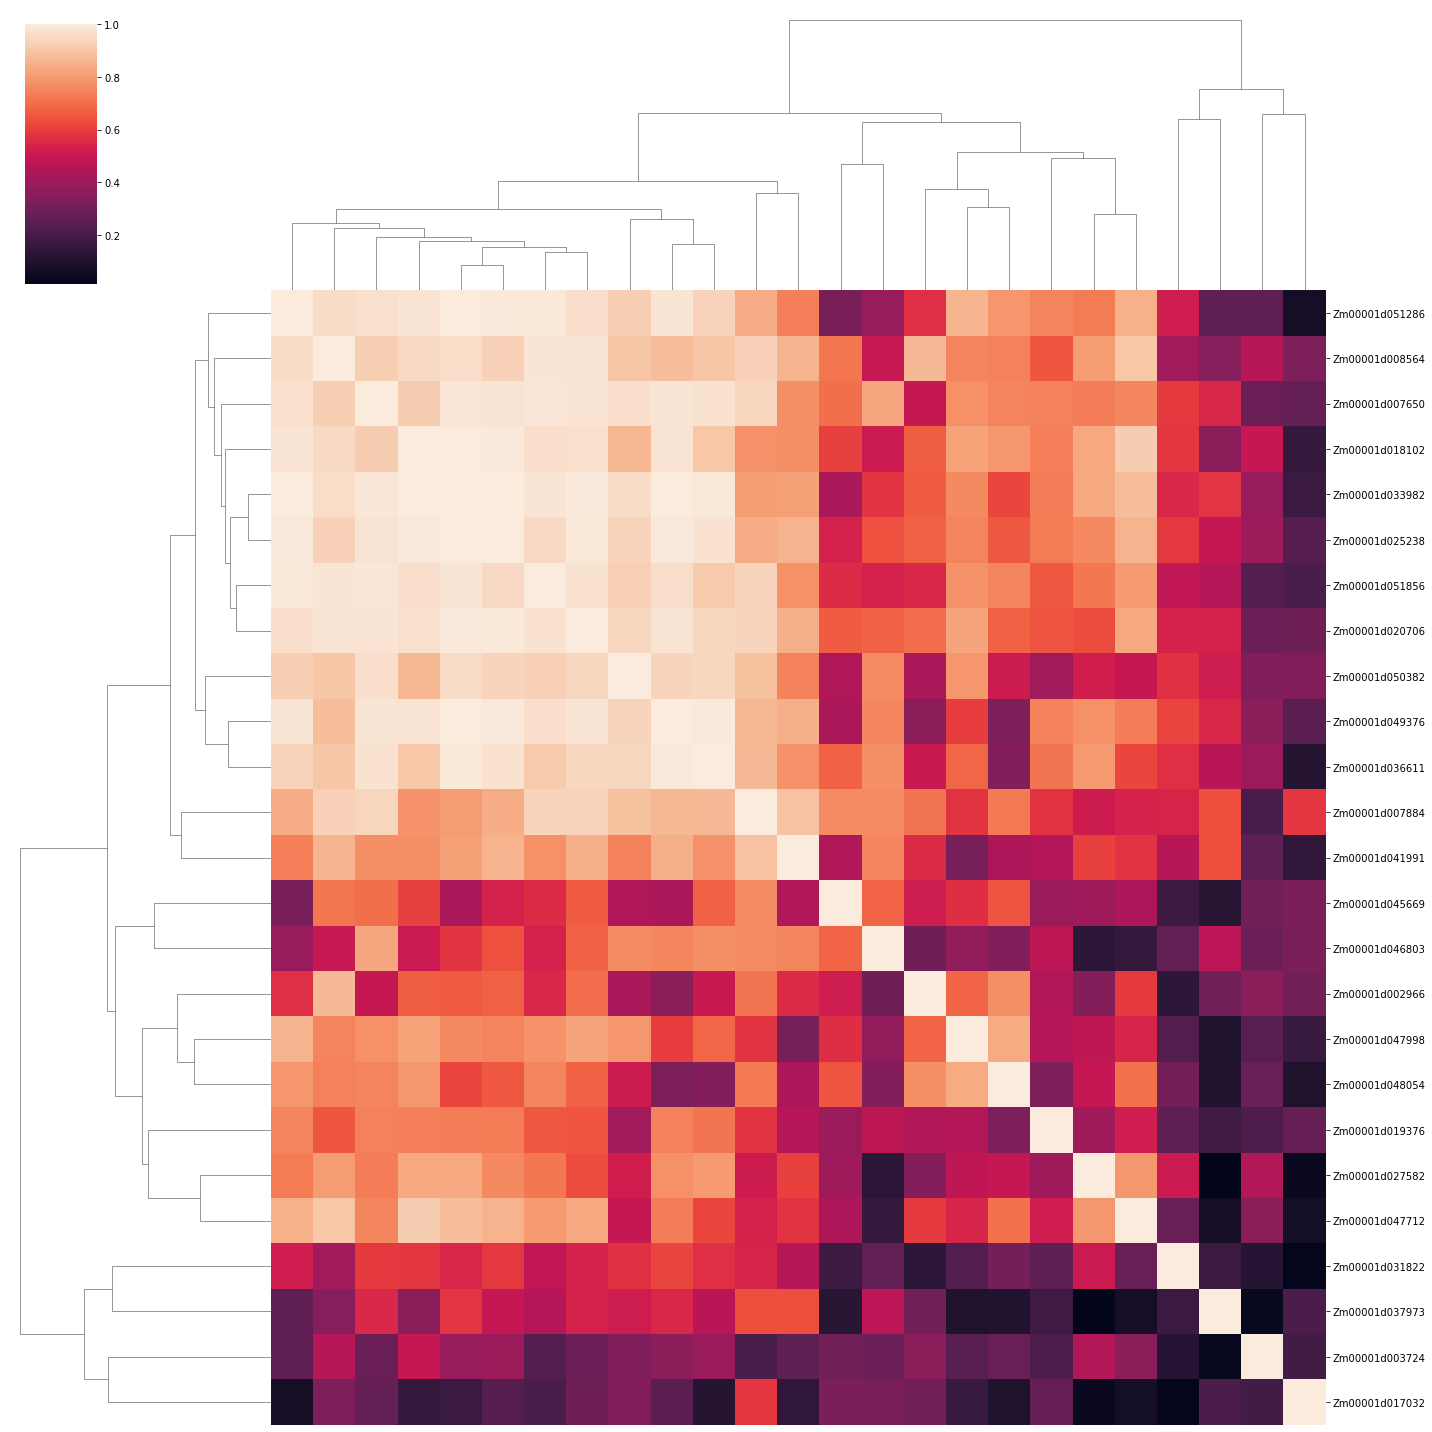

In [17]:
fig = sns.clustermap(coconet_only_25, metric = 'euclidean', figsize= (20,20),xticklabels = False)
fig.savefig('/data/passala/Collaborator_Data/Penelope_Dave_Collab/Figs/top_25_signal_cleaned_no_fea_genes.png',facecolor = 'white')


In [27]:
coconet_only_25.iloc[fig.dendrogram_row.reordered_ind].index.to_series().reset_index(drop = True).to_csv('/data/passala/Collaborator_Data/Penelope_Dave_Collab/Figs/top_25_no_fea_and_signal_cleaned_ordered.csv',header=False,index = False)

In [47]:
coconet_only_25.iloc[fig.dendrogram_row.reordered_ind].index.to_series().reset_index(drop = True)

0     Zm00001d012577
1     Zm00001d030772
2     Zm00001d053283
3     Zm00001d017935
4     Zm00001d051877
5     Zm00001d029869
6     Zm00001d047504
7     Zm00001d034205
8     Zm00001d010793
9     Zm00001d028660
10    Zm00001d008564
11    Zm00001d043068
12    Zm00001d015231
13    Zm00001d012750
14    Zm00001d047901
15    Zm00001d029539
16    Zm00001d020531
17    Zm00001d022107
18    Zm00001d018965
19    Zm00001d034217
20    Zm00001d049860
21    Zm00001d043069
22    Zm00001d028930
23    Zm00001d005766
24    Zm00001d015397
dtype: object

In [38]:
fig.dendrogram_row.reordered_ind

[21,
 4,
 9,
 15,
 8,
 3,
 23,
 5,
 20,
 0,
 19,
 11,
 13,
 22,
 24,
 2,
 17,
 18,
 16,
 6,
 7,
 12,
 1,
 10,
 14]